In [1]:
# !pip uninstall -y hossam
# !pip install --upgrade git+https://github.com/leekh4232/hossam-data-helper.git

# Bagging 분류 하이퍼 파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 최적의 성능을 보이는 모델
from sklearn.linear_model import LogisticRegression

# 배깅 앙상블
from sklearn.ensemble import BaggingClassifier

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기

In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 전처리

`0`값을 포함해서는 안되는 변수에 대해 평균으로 대체

In [4]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [4] 훈련/검증 데이터 분할 및 데이터 표준화

In [5]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. 하이퍼파라미터 튜닝

### [1] 최적 성능을 보인 모형 객체 생성

이전 예제에서 이 데이터에 대한 최적 모형은 LogisticRegression 이었다.

In [6]:
estimator = get_estimator(classname=LogisticRegression)
estimator

LogisticRegression(max_iter=1000, n_jobs=2, random_state=1000)

### [2] 하이퍼파라미터

#### (1) 최적성능을 보인 모형에 대한 파라미터

In [7]:
params = get_hyper_params(classname=LogisticRegression, key='estimator')
params

{'estimator__penalty': ['l1', 'l2']}

#### (2) Bagging 모형에 대한 파라미터

In [8]:
bagging_params = get_hyper_params(classname=BaggingClassifier)
bagging_params

{'bootstrap_features': [False, True],
 'n_estimators': [2, 5, 10, 20],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

#### (3) 하이퍼파라미터 결합

In [9]:
params.update(bagging_params)
params

{'estimator__penalty': ['l1', 'l2'],
 'bootstrap_features': [False, True],
 'n_estimators': [2, 5, 10, 20],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

### [3] 하이퍼파라미터 튜닝

In [10]:
rcv = RandomizedSearchCV(
    estimator=BaggingClassifier(estimator=estimator, random_state=get_random_state()),
    param_distributions=params,
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    random_state=get_random_state(),
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.dropna(subset=['mean_test_score'], inplace=True)
result_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

result_df

,n_estimators,max_samples,max_features,estimator__penalty,bootstrap_features,mean_test_score
36,2,0.5,0.5,l2,False,0.784966
40,2,0.7,0.5,l2,False,0.784966
52,2,0.7,0.7,l2,False,0.781674
65,5,0.7,1.0,l2,False,0.780101
62,10,0.5,1.0,l2,False,0.780088
...,...,...,...,...,...,...
115,20,0.7,0.5,l2,True,0.747528
112,2,0.7,0.5,l2,True,0.745875
120,2,0.5,0.7,l2,True,0.744289
136,2,0.7,1.0,l2,True,0.742650


### [4] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.783388 |      0.75974 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.767742 |     0.682927 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.550926 |     0.538462 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0904523 |     0.127451 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.909548 |     0.872549 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.641509 |     0.602151 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.830774 |     0.801471 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

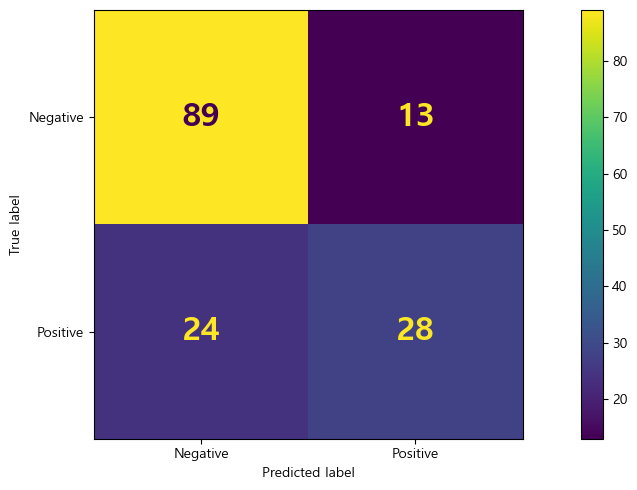


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


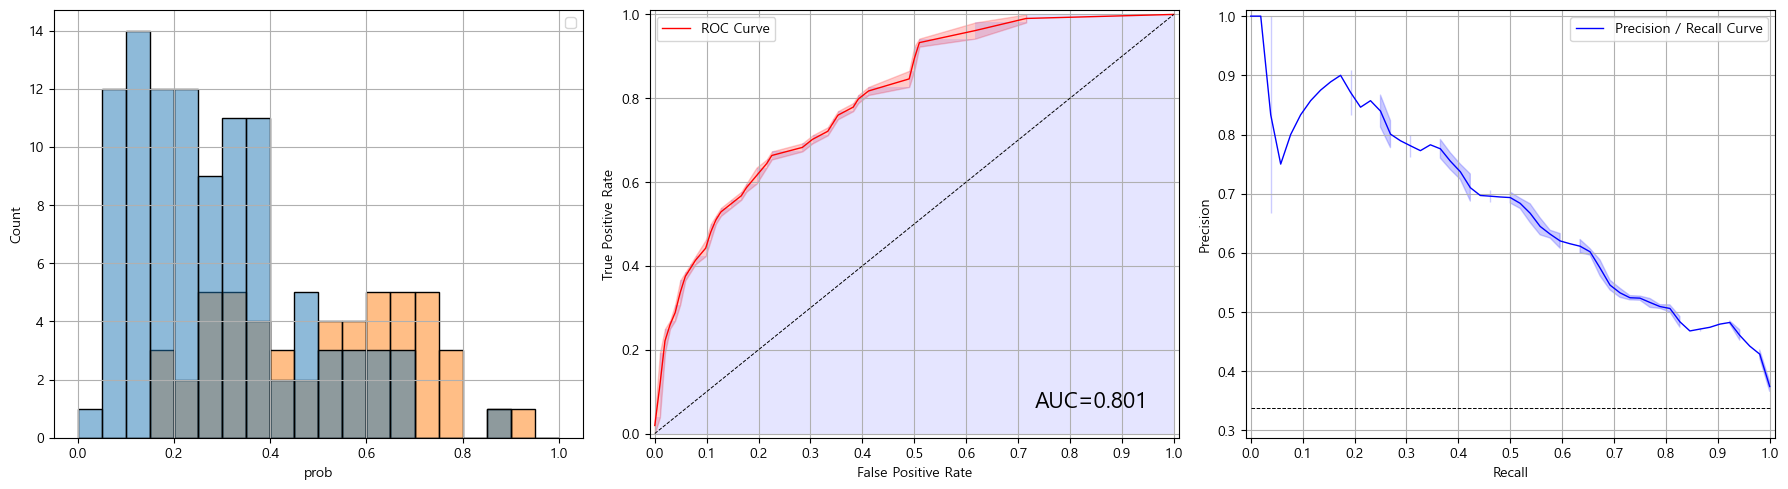


[학습곡선]


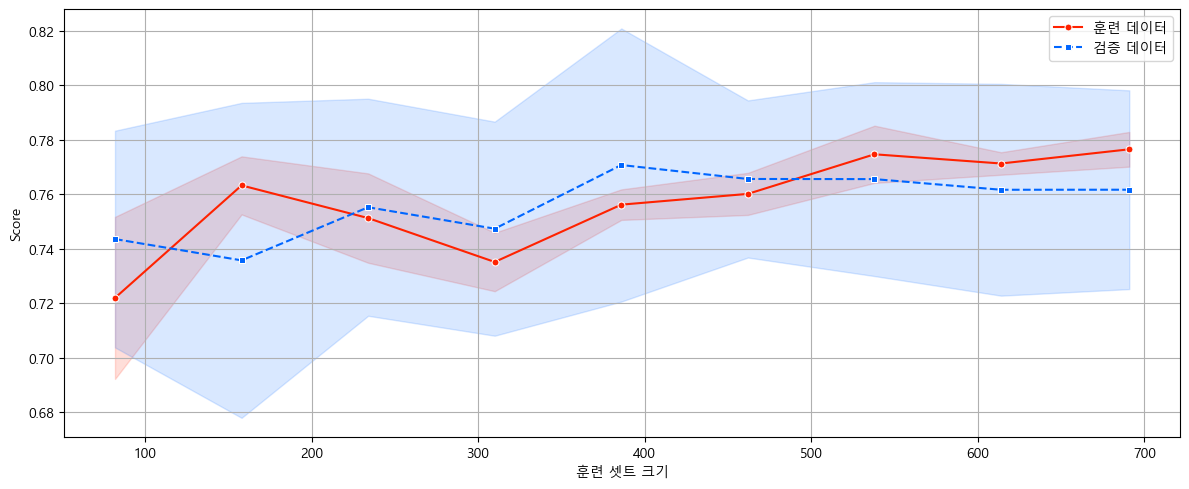

In [11]:
my_classification_result(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [5] 독립변수 확인

In [12]:
my_classification_report(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.72987 |
|  1 | Outcome    | Glucose                  | 1.37433 |
|  2 | Outcome    | BloodPressure            | 1.39985 |
|  3 | Outcome    | SkinThickness            |  1.4874 |
|  4 | Outcome    | Insulin                  | 1.16212 |
|  5 | Outcome    | BMI                      | 1.76203 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.06232 |
|  7 | Outcome    | Age                      | 2.05027 |
+----+------------+--------------------------+---------+


## #03. 모듈화 기능 활용

### [1] 직접 생성한 분석기 객체를 전달하는 경우

[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | estimator__penalty   | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+----------------------+-------------------|
|  0 |              2 |           0.5 |            0.5 | l2                   | False                |          0.784966 |
|  1 |              2 |           0.7 |            0.5 | l2                   | False                |          0.784966 |
|  2 |              2 |           0.7 |            0.7 | l2                   | False                |          0.781674 |
|  3 |              5 |           0.7 |              1 | l2                   | False                |          0.780101 |
|  4 |             10 |           0.5 |              1 | l2                   | False                |          0.780088 |
+---

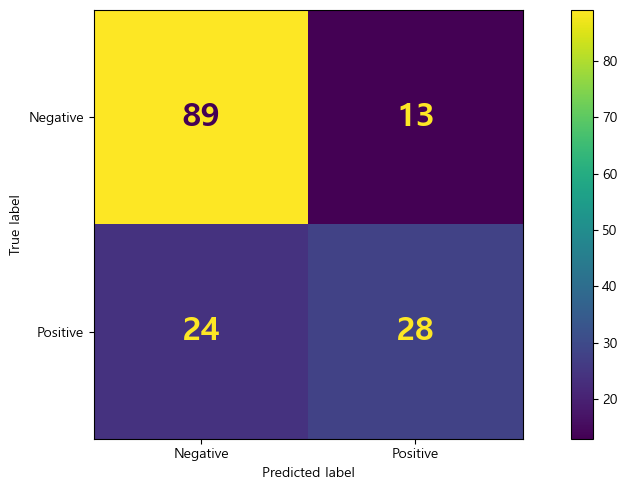


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


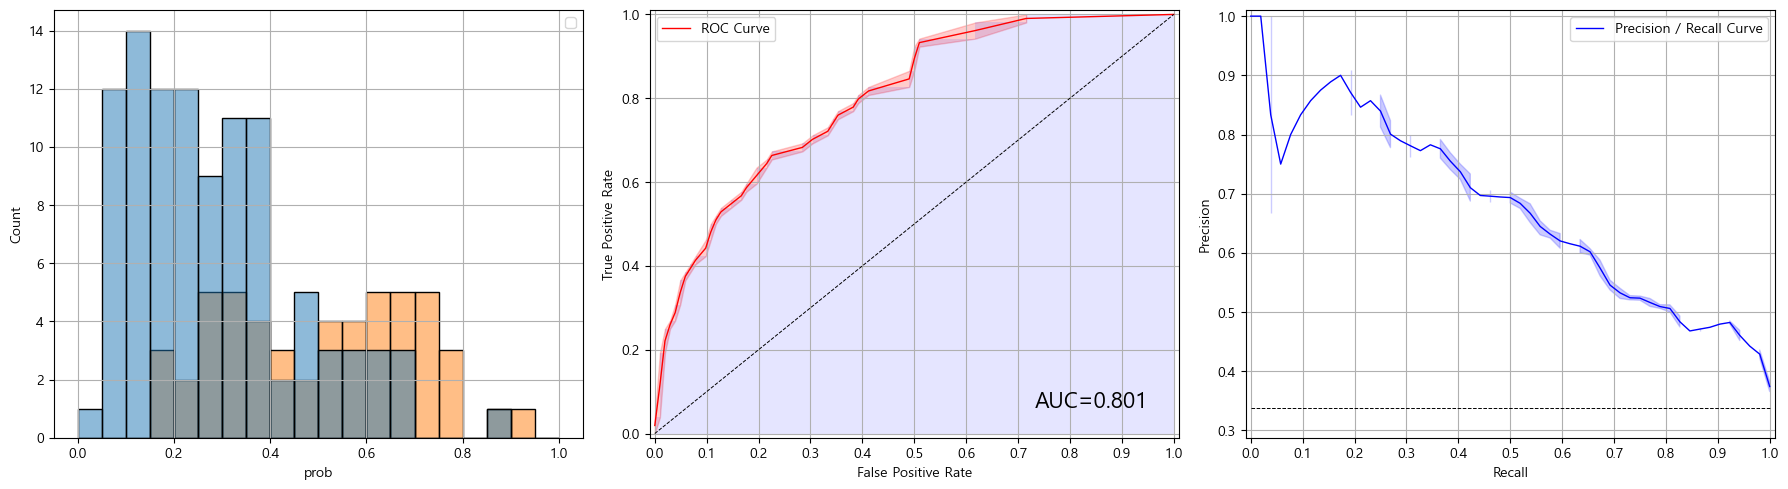


[학습곡선]


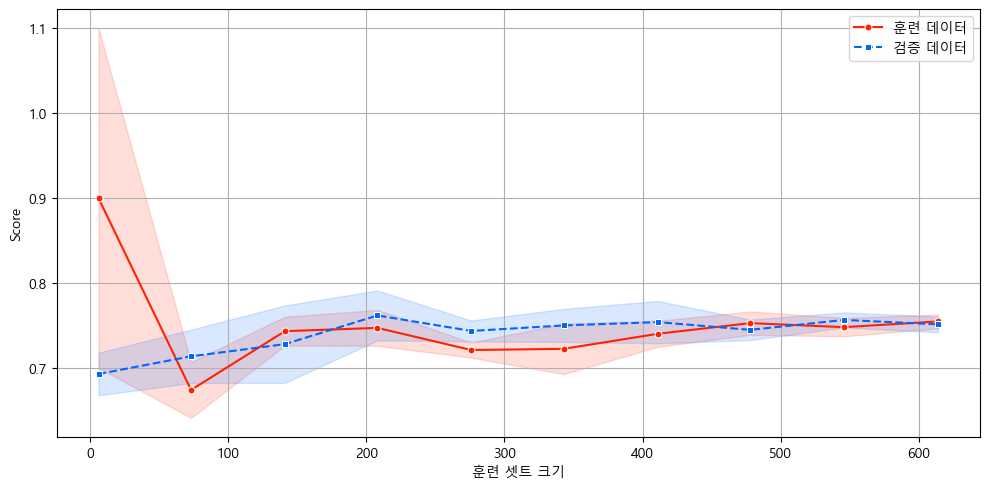

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 2.05027 |
|  1 |       5 | Outcome    | BMI                      | 1.76203 |
|  2 |       0 | Outcome    | Pregnancies              | 1.72987 |
|  3 |       3 | Outcome    | SkinThickness            |  1.4874 |
|  4 |       2 | Outcome    | BloodPressure            | 1.39985 |
|  5 |       1 | Outcome    | Glucose                  | 1.37433 |
|  6 |       4 | Outcome    | Insulin                  | 1.16212 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.06232 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=2,
                                               random_state=1000),
                  max_features=0.5, max_samples=0.5, n_estimators=2, n_jobs=2,
                  random_state=1000)

In [13]:
my_bagging_classification(estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [2] 분석기 객체에 대한 클래스만 전달하는 경우

모듈 내부에서 객체를 생성하여 수행한다.

[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | estimator__penalty   | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+----------------------+-------------------|
|  0 |              2 |           0.5 |            0.5 | l2                   | False                |          0.784966 |
|  1 |              2 |           0.7 |            0.5 | l2                   | False                |          0.784966 |
|  2 |              2 |           0.7 |            0.7 | l2                   | False                |          0.781674 |
|  3 |              5 |           0.7 |              1 | l2                   | False                |          0.780101 |
|  4 |             10 |           0.5 |              1 | l2                   | False                |          0.780088 |
+---

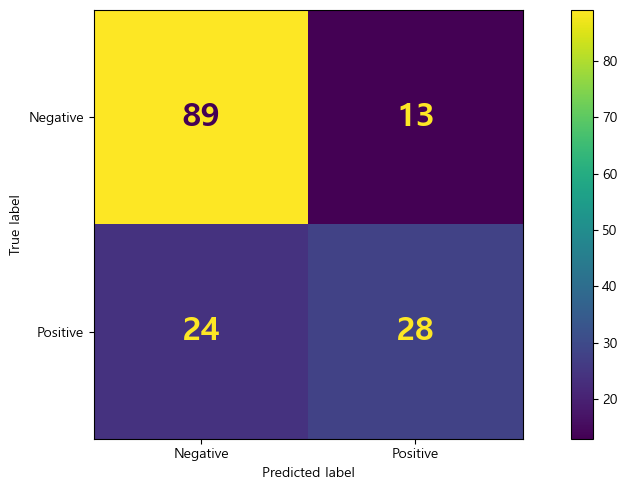


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


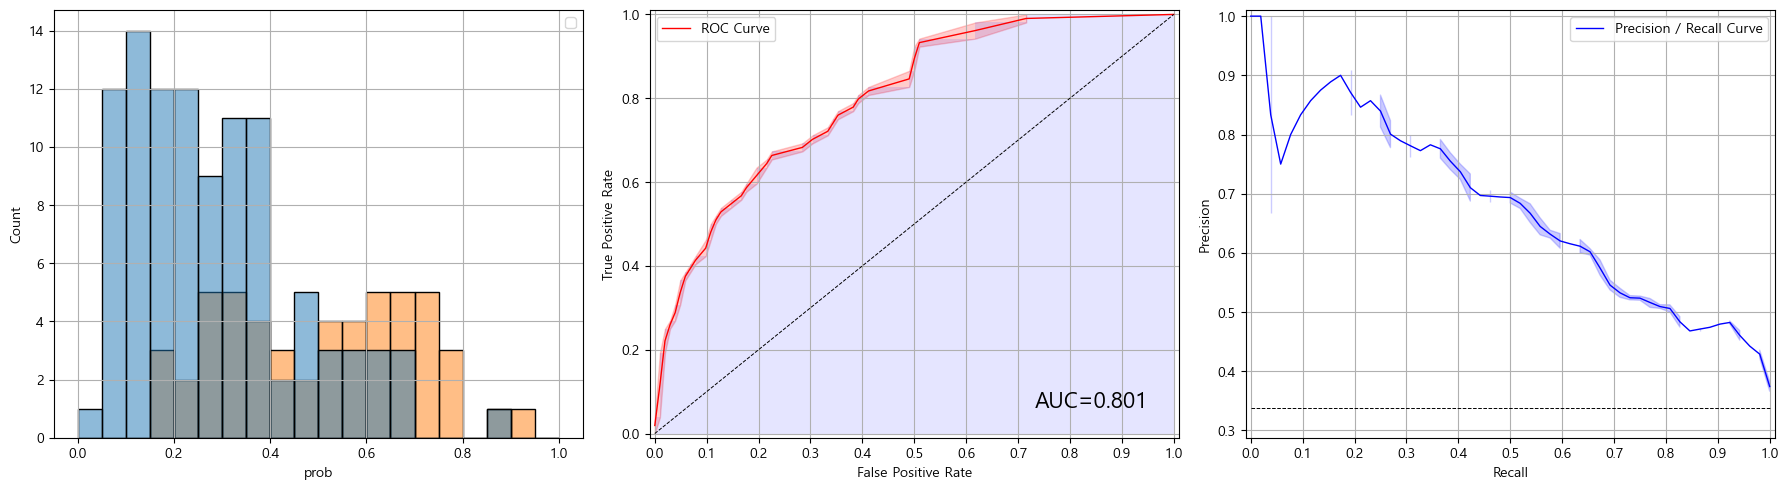


[학습곡선]


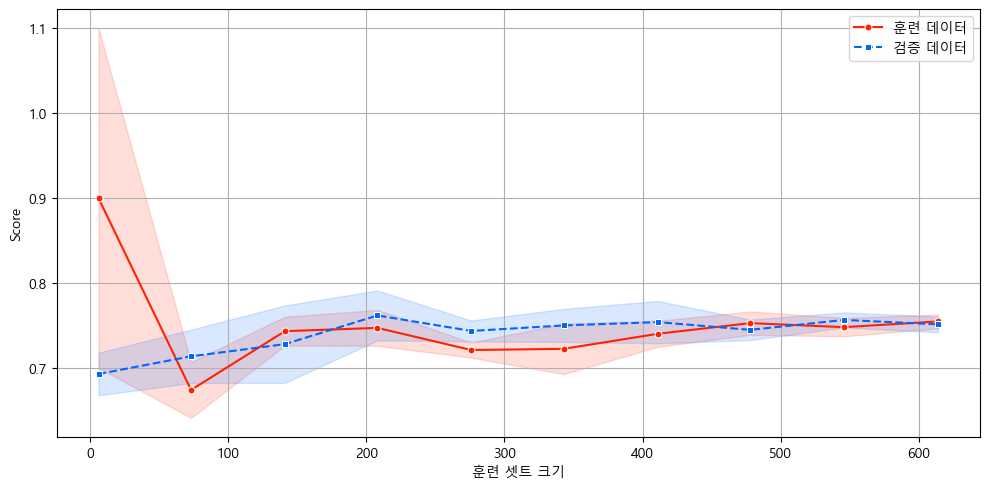

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 2.05027 |
|  1 |       5 | Outcome    | BMI                      | 1.76203 |
|  2 |       0 | Outcome    | Pregnancies              | 1.72987 |
|  3 |       3 | Outcome    | SkinThickness            |  1.4874 |
|  4 |       2 | Outcome    | BloodPressure            | 1.39985 |
|  5 |       1 | Outcome    | Glucose                  | 1.37433 |
|  6 |       4 | Outcome    | Insulin                  | 1.16212 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.06232 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=2,
                                               random_state=1000),
                  max_features=0.5, max_samples=0.5, n_estimators=2, n_jobs=2,
                  random_state=1000)

In [14]:
my_bagging_classification(estimator=LogisticRegression, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### [3] 분석기 객체 정보를 전달하지 않는 경우

모듈 내부에서 최적 모형을 찾은 후 배깅에 적용한다.

가지치기를 하지 않습니다.


==================== 모델 성능 비교 ====================
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| LogisticRegression     |                  0.234232 |           0.746753 |            0.644444 |         0.557692 |            0.156863 |      0.843137 |   0.597938 | 0.824472 |
| SVC                    |                         0 |           0.733766 |            0.622222 |         0.538462 |            0.166667 |      0.833333 |    0.57732 |   0.7977 |
| GaussianNB             |                         0 |     

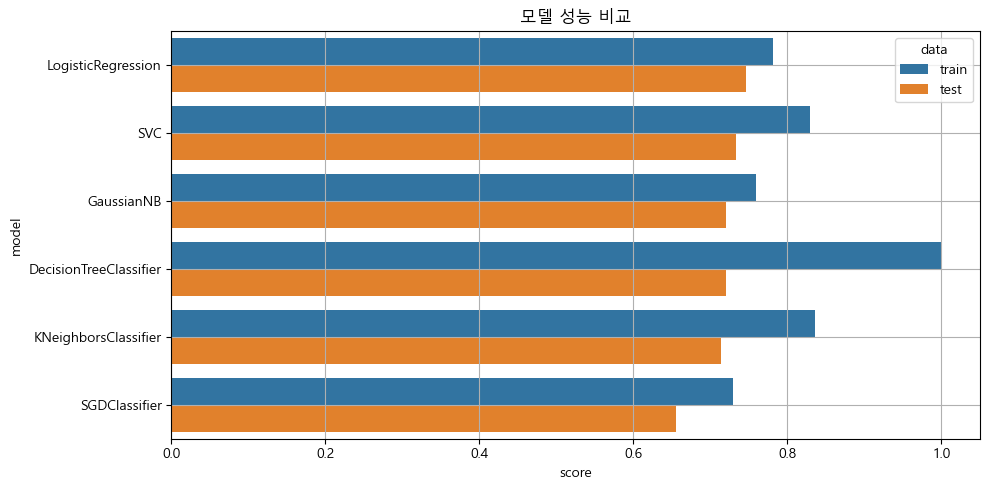



==================== 최고 성능 모델: LogisticRegression ====================
[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.290509 |     0.234232 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.781759 |     0.746753 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision)       |     0.735632 |     0.644444 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)          |     0.592593 |     0.557692 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout)       |     0.115578 |     0.156863 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)             |     0.884422 |     0.843137 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율

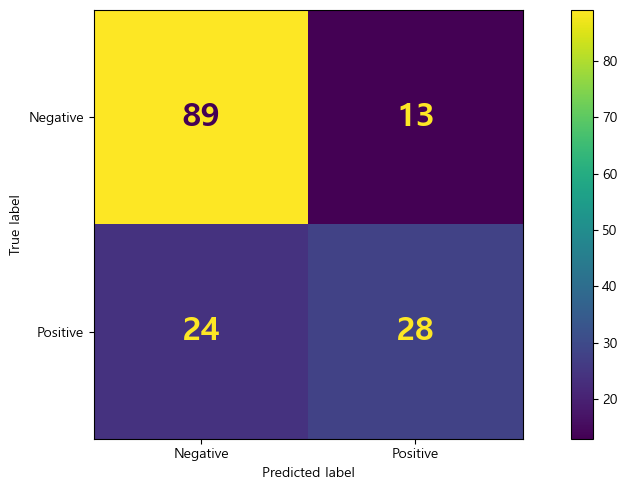

[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


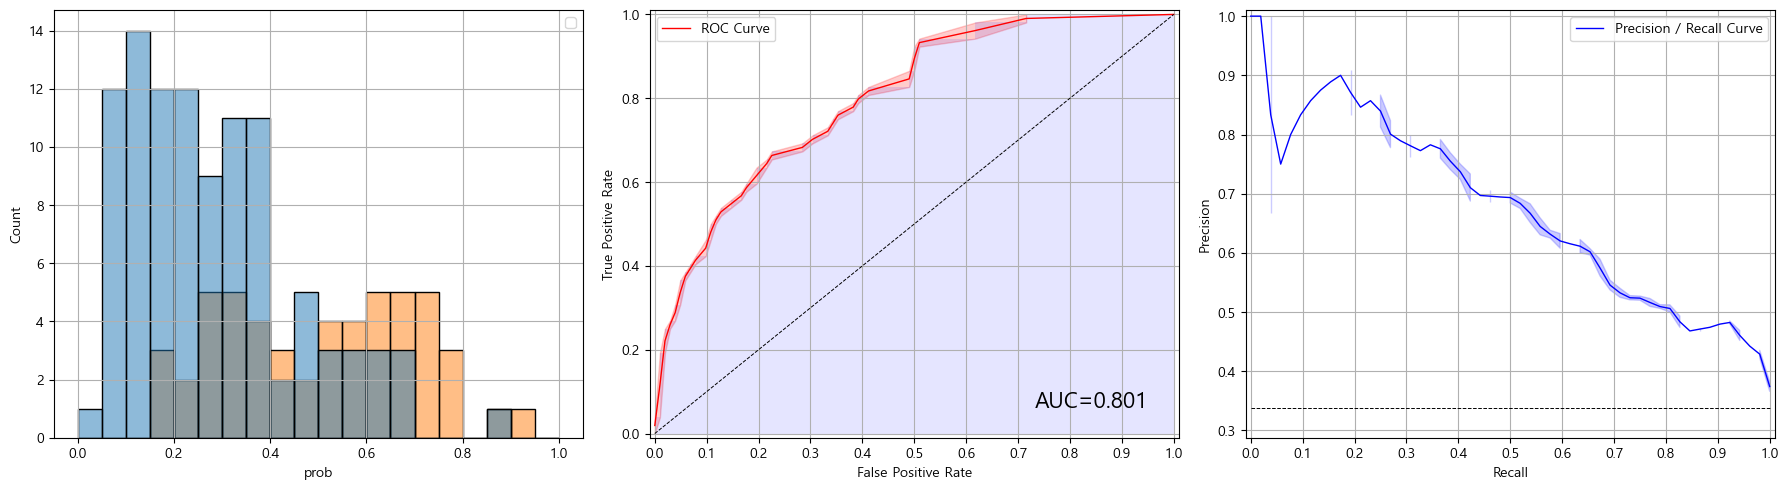


[학습곡선]


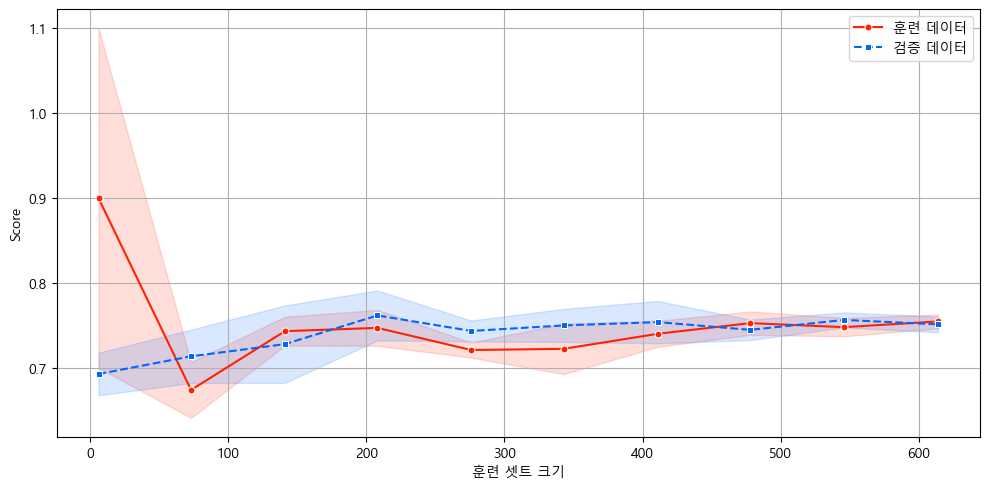

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 2.05027 |
|  1 |       5 | Outcome    | BMI                      | 1.76203 |
|  2 |       0 | Outcome    | Pregnancies              | 1.72987 |
|  3 |       3 | Outcome    | SkinThickness            |  1.4874 |
|  4 |       2 | Outcome    | BloodPressure            | 1.39985 |
|  5 |       1 | Outcome    | Glucose                  | 1.37433 |
|  6 |       4 | Outcome    | Insulin                  | 1.16212 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.06232 |
+----+---------+------------+--------------------------+---------+


BaggingClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=2,
                                               random_state=1000),
                  max_features=0.5, max_samples=0.5, n_estimators=2, n_jobs=2,
                  random_state=1000)

In [16]:
my_bagging_classification(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)